## Code from BSOiD 
https://github.com/YttriLab/B-SOID/blob/master/bsoid_py/utils/likelihoodprocessing.py

In [1]:
import matplotlib.pyplot as plt
import os
import math, scipy
from scipy import signal

"""
likelihood processing utilities
Forward fill low likelihood (x,y)
"""

import glob
import re
import pandas as pd
import numpy as np
from tqdm import tqdm


def boxcar_center(a, n):
    a1 = pd.Series(a)
    moving_avg = np.array(a1.rolling(window=n, min_periods=1, center=True).mean())

    return moving_avg


def convert_int(s):
    """ Converts digit string to integer
    """
    if s.isdigit():
        return int(s)
    else:
        return s


def alphanum_key(s):
    """ Turn a string into a list of string and number chunks.
        "z23a" -> ["z", 23, "a"]
    """
    return [convert_int(c) for c in re.split('([0-9]+)', s)]


def sort_nicely(l):
    """ Sort the given list in the way that humans expect.
    """
    l.sort(key=alphanum_key)


def import_folders(folders: list):
    """
    Import multiple folders containing .csv files and process them
    :param folders: list, data folders
    :return filenames: list, data filenames
    :return data: list, filtered csv data
    :return perc_rect_li: list, percent filtered
    """
    filenames = []
    rawdata_li = []
    data_li = []
    perc_rect_li = []
    for i, fd in enumerate(folders):  # Loop through folders
        f = folders
        for j, filename in enumerate(f):
#             logging.info('Importing CSV file {} from folder {}'.format(j + 1, i + 1))
            curr_df = pd.read_csv(filename, low_memory=False)
            curr_df_filt, perc_rect = adp_filt(curr_df)
#             logging.info('Done preprocessing (x,y) from file {}, folder {}.'.format(j + 1, i + 1))
            rawdata_li.append(curr_df)
            perc_rect_li.append(perc_rect)
            data_li.append(curr_df_filt)
        filenames.append(f)
#         logging.info('Processed {} CSV files from folder: {}'.format(len(f), fd))
    data = np.array(data_li)
#     logging.info('Processed a total of {} CSV files, and compiled into a {} data list.'.format(len(data_li),
#                                                                                                data.shape))
    return filenames, data, perc_rect_li


def adp_filt(currdf: object):
    """
    :param currdf: object, csv data frame
    :return currdf_filt: 2D array, filtered data
    :return perc_rect: 1D array, percent filtered per BODYPART
    """
    lIndex = []
    xIndex = []
    yIndex = []
    # Changed this to 16 cause we only want head points
    currdf = np.array(currdf[1:])
    currdf = currdf[:,:16]
    for header in range(len(currdf[0])):
        if currdf[0][header] == "likelihood":
            lIndex.append(header)
        elif currdf[0][header] == "x":
            xIndex.append(header)
        elif currdf[0][header] == "y":
            yIndex.append(header)
#     logging.info('Extracting likelihood value...')
    curr_df1 = currdf[:, 1:]
    datax = curr_df1[:, np.array(xIndex) - 1]
    datay = curr_df1[:, np.array(yIndex) - 1]
    data_lh = curr_df1[:, np.array(lIndex) - 1]
    currdf_filt = np.zeros((datax.shape[0] - 1, (datax.shape[1]) * 2))
    perc_rect = []
#     logging.info('Computing data threshold to forward fill any sub-threshold (x,y)...')
    for i in range(data_lh.shape[1]):
        perc_rect.append(0)
    for x in tqdm(range(data_lh.shape[1])):
        a, b = np.histogram(data_lh[1:, x].astype(np.float))
        rise_a = np.where(np.diff(a) >= 0)
        if rise_a[0][0] > 1:
            llh = ((b[rise_a[0][0]] + b[rise_a[0][0]-1]) / 2)
        else:
            llh = ((b[rise_a[0][1]] + b[rise_a[0][1]-1]) / 2)
        data_lh_float = data_lh[1:, x].astype(np.float)
        perc_rect[x] = np.sum(data_lh_float < llh) / data_lh.shape[0]
        for i in range(1, data_lh.shape[0] - 1):
            if data_lh_float[i] < llh:
                currdf_filt[i, (2 * x):(2 * x + 2)] = currdf_filt[i - 1, (2 * x):(2 * x + 2)]
            else:
                currdf_filt[i, (2 * x):(2 * x + 2)] = np.hstack([datax[i, x], datay[i, x]])
    currdf_filt = np.array(currdf_filt[1:])
    currdf_filt = currdf_filt.astype(np.float)
    return currdf_filt, perc_rect


def main(folders: list):
    """
    :param folders: list, data folders
    :return filenames: list, data filenames
    :return data: list, filtered data list
    :retrun perc_rect: 1D array, percent filtered per BODYPART
    """
    filenames, data, perc_rect = import_folders(folders)
    return filenames, data, perc_rect


def calc_distance(data):
    """
    Calculates sum of point movements over time
    
    Parameters
    ----------
    data: np array
    2d array of X and Y positions over time
    
    
    Returns
    -------
    total_dist: float
    sum of euclidean distances traveled by point
    
    """
    d = np.diff(data, axis=0)

    segdists = np.hypot(d[:,0], d[:,1])

    total_dist = np.sum(segdists)
    
    return total_dist

def quad_checker(points_df):
    if points_df['X'] > 400 and points_df['Y'] > 300:
        return 1
    elif points_df['X'] < 400 and points_df['Y'] > 300:
        return 2
    elif points_df['X'] < 400 and points_df['Y'] < 300:
        return 3 
    else: 
        return 4

def count_crosses(data, method = 'quads', downsample = False):
    """
    Calculates number of midline crosses over time
    
    Parameters
    ----------
    data: pandas df
    df of X and Y and quadrant positions over time
    
    method: string, 'quads', 'X' or 'Y'
    quads = count changes in quadrant (I,II,III,IV)
    X = count movements from left to right half
    Y = count movements from bottom to top half 
    
    Returns
    -------
    crosses: integer
    sum of all crosses
    
    see: https://newbedev.com/downsample-a-1d-numpy-array
    """
    if method == 'quads':
        points = data['Quad'].values
    elif method == 'X':
        points = data['X'].values
    else:
        points = data['Y'].values
    #downsample to 2 sec
    if downsample == True:
        # 60fps * 2 sec
        R = 120
        pad_size = math.ceil(float(points.size)/R)*R - points.size
        b_padded = np.append(points, np.zeros(pad_size)*np.NaN)
        if method == 'quads':
            points, counts = scipy.stats.mode(b_padded.reshape(-1,R), axis=1)
        else:
            points = np.mean(b_padded.reshape(-1,R), axis=1)
    else: 
        pass
#   count crosses
    crosses = 0
    cross_idx = []
    if method == 'quads':
        for x in range(len(points)-1):
            if (points[x] != points[x+1]):
                crosses += 1
                cross_idx.append(x)
            else:
                pass
    elif method == 'X': 
        for x in range(len(points)-1): 
            if (points[x] >= 400 and points[x+1] <= 400) or (points[x] <= 400 and points[x+1] >= 400):
                crosses += 1
            else: 
                pass
    else:
        for x in range(len(points)-1):
            if (points[x] >= 300 and points[x+1] <= 300) or (points[x] <= 300 and points[x+1] >= 300):
                crosses += 1
            else: 
                pass
                
    return crosses, cross_idx 

In [2]:
times_df = pd.read_excel('/Users/bishopmn/Documents/Projects/Marm_breathing/Pleth_DLC/20210301_DLCtimesync.xlsx', sheet_name='Master')
times_df = times_df.loc[:7,:]

# Screws to right of “Aerosol” in pleth videos = 3.4 cm
folder = '/Users/bishopmn/Documents/Projects/Marm_breathing/Pleth_DLC/'
METHOD = 'quads'
os.chdir(folder)
files = [i for i in os.listdir(folder) if '.csv' in i]

# points_dict = {
#     0:'tuft_base_L',
#     1:'tuft_base_R',
#     2:'tuft_tip_L',
#     3:'tuft_tip_R',
#     4:'forehead',
# }

# Columns
animals = []
base_len = []
chall_len = []
base_activity = []
chall_activity = []
net_mvmt_base = []
net_mvmt_chall = []
for index, row in times_df.iterrows():
    # check that IDs match file names
#     try:
    filename = [i for i in files if str(row.video_name) in i]
    if len(filename)>0: 
        print(filename[0])

        filenames, data, perc_rect = main(filename)

        print(perc_rect)

        data = data[0,:,:]
        framerate = 60

        # Average all the points to clean the signal
        points_df = pd.DataFrame(data)
        points_df['X'] = points_df[[0,2,4,6,8]].mean(axis=1)
        points_df['Y'] = points_df[[1,3,5,7,9]].mean(axis=1)
        points_df['Quad'] = [quad_checker(row) for index, row in points_df.iterrows()]
        
#         # plot entire signal
#         sns.set(rc={'figure.figsize':(80,10)})
#         ax = sns.lineplot(x = points_df.index, y = points_df.Quad)
#         plt.axvline(row.video_challstart_ss*framerate, c='red')
#         plt.axvline(row.video_challend_ss * framerate, c = 'red')
#         plt.show()

        if row.video_challstart_ss < 0:
            chall_start = 0
        else:
            chall_start = row.video_challstart_ss * framerate
        
        

        # chop up the x,y signal based on when the challenge is, start challenge 5 mins after gas change
        chall_data = points_df.loc[300 * framerate + chall_start:row.video_challend_ss * framerate, : ].reset_index(drop=True)
        chall_data['Condition'] = "1"
        # baseline is the 5 mins before the gas change
        base_data = points_df.loc[chall_start-300*framerate:chall_start, : ].reset_index(drop = True)
        base_data['Condition'] = "0"

        scatter_df = pd.DataFrame()
        scatter_df = scatter_df.append([chall_data,base_data])
        scatter_df = scatter_df[scatter_df.index < chall_start]


        # plot 1 min of challenge and 1 min of baseline
        sns.set(rc={'figure.figsize':(8,6)})
        ax = sns.scatterplot(data=scatter_df, x = 'X', y = 'Y', hue = scatter_df.Condition.to_list())
        plt.savefig(row.animal_name + '.pdf')
        plt.show(ax)
            
        # given in number of crosses per hour 
        if len(base_data) > 0:
            # Count quadrant changes
            base_crosses, base_idxs = count_crosses(base_data, method=METHOD, downsample=True)
            base_activity.append(60*base_crosses/(len(base_data)/framerate))
            
            # Count net movement 
            base_net = calc_distance(base_data.loc[:, ['X','Y']].to_numpy())/len(base_data)
            net_mvmt_base.append(base_net)
        else: 
            base_activity.append(None)
            net_mvmt_base.append(None)
            
        if len(chall_data) > 0:
            # Count quadrant changes
            chall_crosses, chall_idxs = count_crosses(chall_data, method= METHOD, downsample=True)
            chall_activity.append(60*chall_crosses/(len(chall_data)/framerate))
            
            # Count net movement 
            chall_net = calc_distance(chall_data.loc[:, ['X','Y']].to_numpy())/len(chall_data)
            net_mvmt_chall.append(chall_net)
        else: 
            chall_activity.append(None)
            net_mvmt_chall.append(None)
            
          # Prep for df
        animals.append(filenames[0][:5])
        base_len.append(len(base_data)/framerate)
        chall_len.append(len(chall_data)/framerate)


movement_df = pd.DataFrame({"Animal": animals,
                            "Base_length": base_len,
                            "Challenge_length": chall_len,
                            "Baseline_rate": base_activity,
                            "Challenge_rate": chall_activity, 
                            "Baseline_Net": net_mvmt_base, 
                            "Challenge_Net": net_mvmt_chall})

movement_df['Percent_change']= 100*(movement_df.Challenge_rate-movement_df.Baseline_rate)/movement_df.Baseline_rate

Amber_e3v8150-20201027T110628-113733DLC_resnet_50_Marm_PlethApr29shuffle5_500000.csv


KeyboardInterrupt: 

# Quadrant Changes

In [185]:
movement_df

,Animal,Base_length,Challenge_length,Baseline_rate,Challenge_rate,Baseline_Net,Challenge_Net,Percent_change
0,[Amber_e3v8150-20201027T110628-113733DLC_resne...,300.016667,149.016667,2.799844,4.429035,1.670775,1.576965,58.188601
1,[Cassius_e3v8163-20200929T115709-122507DLC_res...,257.016667,319.016667,7.236885,7.711196,2.782811,2.020922,6.554078
2,[Chatterbox_e3v8150-20201009T122411-125641DLC_...,300.016667,0.000000,7.399589,NaN,2.043415,NaN,NaN
3,[Chatterbox_e3v8150-20201009T125641-132221DLC_...,0.016667,196.016667,0.000000,4.591446,0.000000,2.753332,inf
4,[Datil_e3v8163-20200820T1115_fixedDLC_resnet_5...,300.016667,0.000000,6.799622,NaN,2.362277,NaN,NaN
5,[Datil_e3v8163-20200820T1214-1232DLC_resnet_50...,0.016667,66.016667,0.000000,1.817723,0.000000,2.893708,inf
6,[Dewey_e3v8150-20201020T122214-125252DLC_resne...,93.016667,373.016667,3.870274,3.056164,2.283644,1.993003,-21.034955
7,[Green_e3v8163-20200817T1146_fixedDLC_resnet_5...,300.016667,309.083333,2.199878,2.717714,1.276230,1.298322,23.539302


In [25]:
folder = '/Users/bishopmn/Documents/Projects/Marm_breathing/Pleth_DLC/'
METHOD = 'quads'
os.chdir(folder)
filename = ['Datil_e3v8163-20200820T1214-1232DLC_resnet_50_Marm_PlethApr29shuffle5_500000.csv']
filenames, data, perc_rect = main(filename)

print(perc_rect)

data = data[0,:,:]
framerate = 60

# Average all the points to clean the signal
points_df = pd.DataFrame(data)
points_df['X'] = points_df[[0,2,4,6,8]].mean(axis=1)
points_df['Y'] = points_df[[1,3,5,7,9]].mean(axis=1)
points_df['Quad'] = [quad_checker(row) for index, row in points_df.iterrows()]

row= times_df[times_df.video_name == "e3v8163-20200820T1214-1232"]

chall_start = row.video_challstart_ss.values[0]
    
# chop up the x,y signal based on when the challenge is, start challenge 5 mins after gas change
chall_data = points_df.loc[300 * framerate + chall_start*framerate:row.video_challend_ss.values[0]*framerate, : ].reset_index(drop=True)
chall_data['Condition'] = "1"
# baseline is the 5 mins before the gas change
# base_data = points_df.loc[chall_start*framerate-300*framerate:chall_start*framerate, : ].reset_index(drop = True)
# base_data['Condition'] = "0"

# scatter_df = pd.DataFrame()
scatter_df = scatter_df.append(chall_data)
scatter_df = scatter_df[scatter_df.index < row.video_challend_ss.values[0]*60]

100%|██████████| 5/5 [00:03<00:00,  1.62it/s]


[[0.048588153225561856, 0.03733584058718267, 0.045236723180977226, 0.11569257832640806, 0.09646355888508083]]


In [33]:
scatter_df = scatter_df[scatter_df.index < 18000]

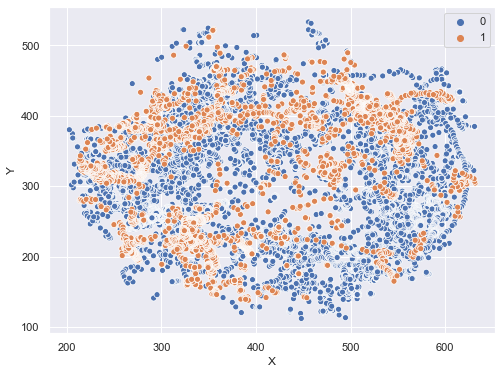

In [34]:
# plot 1 min of challenge and 1 min of baseline
sns.set(rc={'figure.figsize':(8,6)})
sns.scatterplot(data=scatter_df, x = 'X', y = 'Y', hue = scatter_df.Condition.to_list())
plt.savefig(row.animal_name.values[0]+'.pdf')
crosses, cross_idxs = count_crosses(points_df)

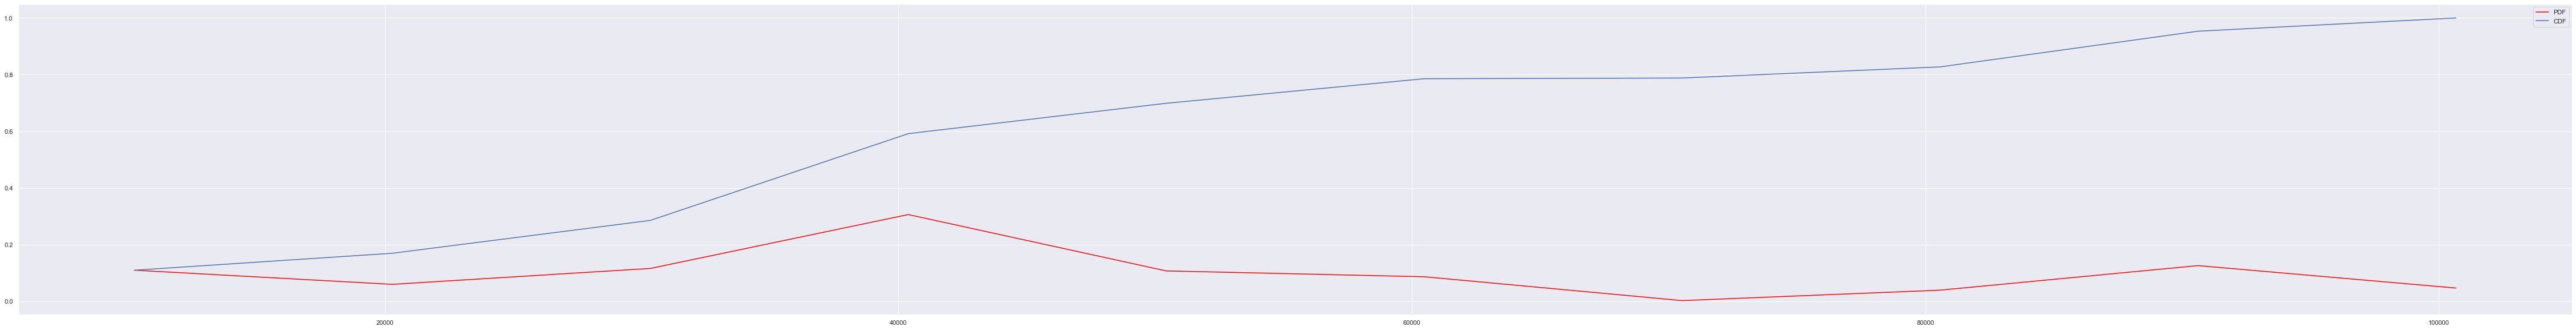

In [90]:
# from https://www.geeksforgeeks.org/how-to-calculate-and-plot-a-cumulative-distribution-function-with-matplotlib-in-python/
# getting data of the histogram
count, bins_count = np.histogram(cross_idxs, bins=10)
  
# finding the PDF of the histogram using count values
pdf = count / sum(count)
  
# using numpy np.cumsum to calculate the CDF
# We can also find using the PDF values by looping and adding
cdf = np.cumsum(pdf)
  
# plotting PDF and CDF
plt.plot(bins_count[1:], pdf, color="red", label="PDF")
plt.plot(bins_count[1:], cdf, label="CDF")
plt.legend()

In [70]:
import seaborn as sns
sns.set(rc={'figure.figsize':(80,10)})

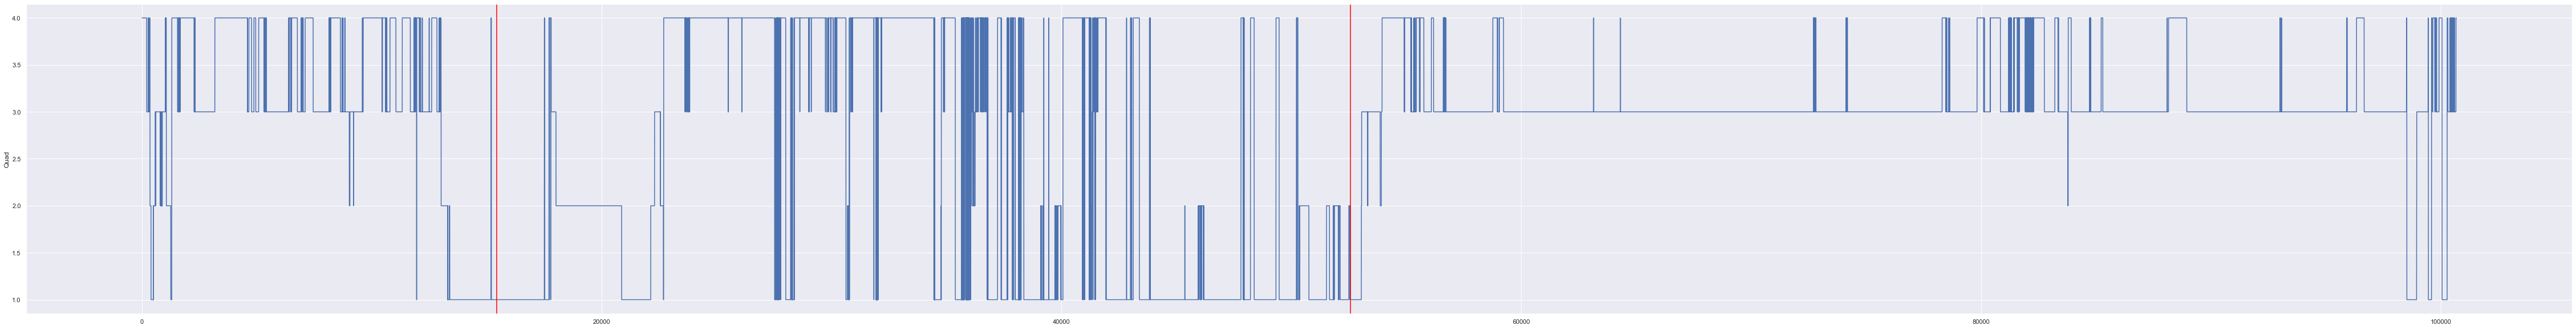

In [89]:
ax = sns.lineplot(x = points_df.index, y = points_df.Quad)
plt.axvline(257*framerate, c='red')
plt.axvline(876 * framerate, c = 'red')

In [82]:
ax.set_xticks(range(0, len(points_df), 10000)) # <--- set the ticks first
ax.set_xticklabels([i/framerate for i in range(0, len(points_df), 10000)])

[Text(0, 0, '0.0'),
 Text(10000, 0, '166.66666666666666'),
 Text(20000, 0, '333.3333333333333'),
 Text(30000, 0, '500.0'),
 Text(40000, 0, '666.6666666666666'),
 Text(50000, 0, '833.3333333333334'),
 Text(60000, 0, '1000.0'),
 Text(70000, 0, '1166.6666666666667'),
 Text(80000, 0, '1333.3333333333333'),
 Text(90000, 0, '1500.0'),
 Text(100000, 0, '1666.6666666666667')]